In [3]:
pip install tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /usr/local/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def compute_alpha_and_hinges(row):
    tck = row.thickness
    Sp = row.span
    wdth = row.width
    UwM = row.wt_kN_per_m3
    n = int(row.n_blocks)

    ri = Sp / 2
    re = ri + tck
    rc = (re + ri) / 2
    si = np.pi * ri
    se = np.pi * re
    sc = np.pi * rc
    angint = np.pi
    ArchA = 0.5 * (re * se - ri * si)
    angblck = angint / n
    blkA = ArchA / n
    wb = sc / n
    Pi = wdth * blkA * UwM

    xc = [rc - rc * np.cos(angblck / 2)]
    yc = [rc * np.sin(angblck / 2)]

    for i in range(1, n):
        angle = angblck / 2 + angblck * i
        if np.cos(angle) < np.pi / 2:
            xc.append(rc - rc * np.cos(angle))
        else:
            xc.append(rc + rc * np.cos(angle))
        yc.append(rc * np.sin(angle))

    xi, yi, xe, ye = [], [], [], []
    for i in range(n + 1):
        xi.append(ri + tck / 2 + ri * np.cos(angblck * i))
        yi.append(ri * np.sin(angblck * i))
        xe.append(re - tck / 2 + re * np.cos(angblck * i))
        ye.append(re * np.sin(angblck * i))

    xi = xi[::-1]
    xe = xe[::-1]

    Xa, Xd = xi[0], xe[n]
    Ya = Yd = 0

    numsumab = np.zeros((n, n))
    densumab = np.zeros((n, n))
    numsumbc = np.zeros((n, n))
    densumbc = np.zeros((n, n))
    numsumcd = np.zeros((n, n))
    densumcd = np.zeros((n, n))

    for b in range(n):
        for c in range(n):
            Xb, Yb = xe[b], ye[b]
            Xc, Yc = xi[c], yi[c]
            AB = np.hypot(Yb - Ya, Xb - Xa)
            CD = np.hypot(Yc - Yd, Xc - Xd)

            if (Xc - Xd) == 0 or (Xa - Xb) == 0:
                continue

            mOC = (Yc - Yd) / (Xc - Xd)
            mOB = (Ya - Yb) / (Xa - Xb)

            if (mOC - mOB) == 0:
                continue

            Xo = ((Ya - mOB * Xa) - (Yc - mOC * Xc)) / (mOC - mOB)
            Yo = (mOC * (Ya - mOB * Xa) - mOB * (Yc - mOC * Xc)) / (mOC - mOB)

            OB = np.hypot(Xo - Xb, Yo - Yb)
            OC = np.hypot(Xo - Xc, Yo - Yc)

            if 0 < b < c < n:
                numsum1, densum1 = [], []
                for i in range(b + 1):
                    dxiab = yc[i] - Ya
                    dyiab = xc[i] - Xa
                    numsum1.append(Pi * dyiab)
                    densum1.append(Pi * dxiab)
                numsumab[b, c] = np.abs(np.sum(numsum1))
                densumab[b, c] = np.abs(np.sum(densum1))

                numsum2, densum2 = [], []
                for i in range(b + 1, c + 1):
                    dxibc = (Yo - yc[i]) * AB / OB
                    dyibc = (Xo - xc[i]) * AB / OB
                    numsum2.append(Pi * dyibc)
                    densum2.append(Pi * dxibc)
                numsumbc[b, c] = np.abs(np.sum(numsum2))
                densumbc[b, c] = np.abs(np.sum(densum2))

                numsum3, densum3 = [], []
                for i in range(c + 1, n):
                    dxicd = (yc[i] - Yd) * AB / OB * OC / CD
                    dyicd = (xc[i] - Xd) * AB / OB * OC / CD
                    numsum3.append(Pi * dyicd)
                    densum3.append(Pi * dxicd)
                numsumcd[b, c] = np.abs(np.sum(numsum3))
                densumcd[b, c] = np.abs(np.sum(densum3))

    densum = densumab + densumbc + densumcd
    numsum = numsumab + numsumbc + numsumcd
    with np.errstate(divide='ignore', invalid='ignore'):
        alphamat = np.where(densum != 0, numsum / densum, np.inf)
    A_pos = np.where(alphamat > 0, alphamat, np.inf)
    alpha1 = np.min(A_pos)
    if np.isinf(alpha1):
        return pd.Series([np.nan, np.nan, np.nan], index=['alpha', 'b', 'c'])
    else:
        linearIdx = np.argmin(A_pos)
        B, C = np.unravel_index(linearIdx, A_pos.shape)
        return pd.Series([alpha1, B + 1, C + 1], index=['alpha', 'b', 'c'])

df = pd.read_csv('h_d.csv')
results = pd.DataFrame([compute_alpha_and_hinges(row) for row in tqdm(df.itertuples(index=False), total=len(df))])
df_updated = pd.concat([df, results], axis=1)
df_updated.to_csv('updated_hor_dtset.csv', index=False)


100%|██████████| 68112/68112 [04:55<00:00, 230.57it/s]


📐 Masonry Arch Collapse Mechanism
💡 Note: Live Load is fixed at 50 kN

Invalid input: invalid literal for int() with base 10: ''

✅ Governing Mechanism Identified:
Minimum Collapse Load Factor (λ): 0.0491
Calculated Thickness: 4.200 m
Live Load: 50 kN applied on Block 33

🧩 Hinge Locations:
Hinge A (Intrados)        → Block 1
Hinge B (Extrados)        → Block 19
Hinge (Live Load)         → Block 33
Hinge C (Intrados)        → Block 27
Hinge D (Extrados)        → Block 44


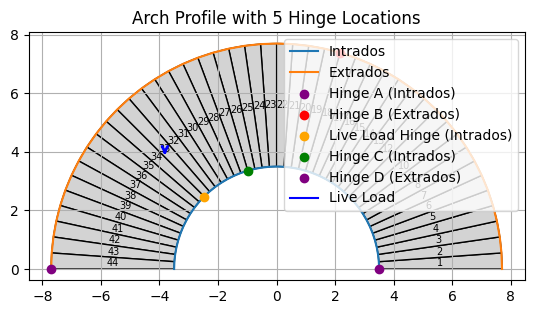

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_float_input(prompt, min_val, max_val):
    while True:
        try:
            value = float(input(prompt))
            if not (min_val <= value <= max_val):
                raise ValueError(f"Value must be between {min_val} and {max_val}")
            return value
        except ValueError as e:
            print(f"Invalid input: {e}")

def get_int_input(prompt, min_val, max_val, even_only=False):
    while True:
        try:
            value = int(input(prompt))
            if even_only and value % 2 != 0:
                raise ValueError("Value must be an even number")
            if not (min_val <= value <= max_val):
                raise ValueError(f"Value must be between {min_val} and {max_val}")
            return value
        except ValueError as e:
            print(f"Invalid input: {e}")

def main():
    print("📐 Masonry Arch Collapse Mechanism")
    print("💡 Note: Live Load is fixed at 50 kN\n")

    Sp = get_float_input("Enter Span (m) [0.5 – 15.0]: ", 0.5, 15.0)
    ts_ratio = get_float_input("Enter t/s Ratio [0.08 – 2.0]: ", 0.08, 2.0)
    tck = ts_ratio * Sp

    wdth = get_float_input("Enter Width (m) [3.0 – 10.0]: ", 3.0, 10.0)
    UwM = get_float_input("Enter Unit Weight (kN/m³) [17 – 24]: ", 17.0, 24.0)
    n = get_int_input("Enter Number of Blocks [8 – 60, even only]: ", 8, 60, even_only=True)
    live_block = get_int_input(f"Enter Live Load Block Index [2 – {n - 1}]: ", 2, n - 1) - 1
    Wl = 50  # Fixed live load in kN

    # Geometry
    ri = Sp / 2
    re = ri + tck
    rc = (re + ri) / 2
    angblck = np.pi / n
    ArchA = 0.5 * (np.pi * re**2 - np.pi * ri**2)
    blkA = ArchA / n
    Pi = wdth * blkA * UwM

    # Centroid coordinates
    xc, yc = np.zeros(n), np.zeros(n)
    for i in range(n):
        theta = angblck * (i + 0.5)
        xc[i] = rc * np.cos(theta)
        yc[i] = rc * np.sin(theta)

    x_A = rc * np.cos(np.pi)
    x_D = rc * np.cos(0)

    # Find governing mechanism
    min_lambda = float('inf')
    best_B = best_C = -1

    for b in range(1, n - 2):
        for c in range(b + 1, n - 1):
            work_ab = sum(Pi * (xc[i] - x_A) for i in range(0, b + 1))
            work_bc = sum(Pi * (xc[i] - xc[b]) for i in range(b + 1, c + 1))
            work_cd = sum(Pi * (xc[i] - x_D) for i in range(c + 1, n))

            total_internal_work = work_ab + work_bc + work_cd

            if live_block <= b:
                delta_yl = xc[live_block] - x_A
            elif b < live_block <= c:
                delta_yl = xc[live_block] - xc[b]
            else:
                delta_yl = xc[live_block] - x_D

            if delta_yl != 0:
                lambda_val = -total_internal_work / (Wl * delta_yl)
                if lambda_val > 0 and lambda_val < min_lambda:
                    min_lambda = lambda_val
                    best_B, best_C = b, c

    if best_B != -1:
        print("\n✅ Governing Mechanism Identified:")
        print(f"Minimum Collapse Load Factor (λ): {min_lambda:.4f}")
        print(f"Calculated Thickness: {tck:.3f} m")
        print(f"Live Load: 50 kN applied on Block {live_block + 1}")

        print("\n🧩 Hinge Locations:")
        print(f"Hinge A (Intrados)        → Block 1")
        print(f"Hinge B (Extrados)        → Block {best_B + 1}")
        print(f"Hinge (Live Load)         → Block {live_block + 1}")
        print(f"Hinge C (Intrados)        → Block {best_C + 1}")
        print(f"Hinge D (Extrados)        → Block {n}")

        # Plotting
        fig, ax = plt.subplots()
        theta_vals = [angblck * i for i in range(n + 1)]
        xi = ri * np.cos(theta_vals)
        yi = ri * np.sin(theta_vals)
        xe = re * np.cos(theta_vals)
        ye = re * np.sin(theta_vals)

        ax.plot(xi, yi, label='Intrados')
        ax.plot(xe, ye, label='Extrados')

        for i in range(n):
            theta1 = angblck * i
            theta2 = angblck * (i + 1)
            arc = patches.Wedge(center=(0, 0), r=re, theta1=np.degrees(theta1), theta2=np.degrees(theta2),
                                width=tck, color='lightgray', ec='black')
            ax.add_patch(arc)
            label_x = rc * np.cos((theta1 + theta2) / 2)
            label_y = rc * np.sin((theta1 + theta2) / 2)
            ax.text(label_x, label_y, str(i + 1), ha='center', va='center', fontsize=7)

        def get_hinge_pos(index, is_extrados):
            theta = angblck * index
            r = re if is_extrados else ri
            return r * np.cos(theta), r * np.sin(theta)

        ax.scatter(*get_hinge_pos(0, False), color='purple', label='Hinge A (Intrados)', zorder=5)
        ax.scatter(*get_hinge_pos(best_B, True), color='red', label='Hinge B (Extrados)', zorder=5)
        ax.scatter(*get_hinge_pos(live_block + 1, False), color='orange', label='Live Load Hinge (Intrados)', zorder=5)
        ax.scatter(*get_hinge_pos(best_C, False), color='green', label='Hinge C (Intrados)', zorder=5)
        ax.scatter(*get_hinge_pos(n, True), color='purple', label='Hinge D (Extrados)', zorder=5)

        ax.annotate('', xy=(xc[live_block], yc[live_block] - 0.3), xytext=(xc[live_block], yc[live_block]),
                    arrowprops=dict(arrowstyle='->', color='blue', lw=2))
        ax.plot([], [], color='blue', label='Live Load')

        ax.set_aspect('equal')
        ax.set_title('Arch Profile with 5 Hinge Locations')
        ax.grid(True)
        ax.legend()
        plt.show()
    else:
        print("❌ No valid collapse mechanism found.")

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# Read the dataset
df = pd.read_csv('arch_dataset_outputs.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Extract features and targets
features = ['Span', 'Thickness', 'Width', 'Blocks', 'Unit Weight', 'Load Position']
targets = ['Lambda', 'Hinge B', 'Hinge C']

X = df[features].values
y = df[targets].values

# Split data: 50% train, 20% validation, 30% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2/0.7, random_state=42)

print(f"\nData split: Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(3)  # 3 outputs: Lambda, Hinge B, Hinge C
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nModel summary:")
model.summary()

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=10,
    batch_size=8,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
test_predictions = model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, test_predictions)

print("\nTest Results:")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Detailed evaluation for each output
y_test_df = pd.DataFrame(y_test, columns=targets)
test_pred_df = pd.DataFrame(test_predictions, columns=targets)

for i, target in enumerate(targets):
    mae = mean_absolute_error(y_test[:, i], test_predictions[:, i])
    mse = mean_squared_error(y_test[:, i], test_predictions[:, i])
    print(f"\n{target}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")

# Sample predictions
print("\nSample Predictions vs Actual Values:")
for i in range(min(5, len(X_test))):
    print(f"Example {i+1}:")
    print(f"  Actual: Lambda={y_test[i, 0]:.4f}, Hinge B={y_test[i, 1]:.4f}, Hinge C={y_test[i, 2]:.4f}")
    print(f"  Predicted: Lambda={test_predictions[i, 0]:.4f}, Hinge B={test_predictions[i, 1]:.4f}, Hinge C={test_predictions[i, 2]:.4f}")

Dataset shape: (430080, 12)

First few rows:
   Width  Span  Thickness  Unit Weight  Blocks  Load Position   Lambda  \
0    5.0   2.0       0.16       1900.0       8              2   3.3614   
1    5.0   2.0       0.16       1900.0       8              3   3.9576   
2    5.0   2.0       0.16       1900.0       8              4      NaN   
3    5.0   2.0       0.16       1900.0       8              5  57.1351   
4    5.0   2.0       0.16       1900.0       8              6  14.3311   

   Hinge A  Hinge B  Live Load Hinge  Hinge C  Hinge D  
0      1.0      3.0              2.0      7.0      8.0  
1      1.0      3.0              3.0      7.0      8.0  
2      NaN      NaN              NaN      NaN      NaN  
3      1.0      4.0              5.0      5.0      8.0  
4      1.0      4.0              6.0      5.0      8.0  

Checking for missing values:
Width                0
Span                 0
Thickness            0
Unit Weight          0
Blocks               0
Load Position        0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1/10 - Loss: 165903.763804, Train MAE: 49.8401, Val MAE: 50.7573, Val MSE: 311105.3997


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 2/10 - Loss: 145548.320904, Train MAE: 46.8838, Val MAE: 47.7056, Val MSE: 316221.5411


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 3/10 - Loss: 140802.781038, Train MAE: 45.5720, Val MAE: 46.3873, Val MSE: 308413.8874


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 4/10 - Loss: 138969.529819, Train MAE: 44.0556, Val MAE: 44.8980, Val MSE: 306075.6347


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 5/10 - Loss: 138083.525615, Train MAE: 43.6991, Val MAE: 44.5673, Val MSE: 305758.5957


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 6/10 - Loss: 137252.698051, Train MAE: 43.6718, Val MAE: 44.5132, Val MSE: 305890.1950


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 7/10 - Loss: 136656.891706, Train MAE: 43.5701, Val MAE: 44.3714, Val MSE: 301490.2723


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 8/10 - Loss: 135765.055100, Train MAE: 42.9953, Val MAE: 43.7819, Val MSE: 299432.0564


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 9/10 - Loss: 134919.807497, Train MAE: 42.5650, Val MAE: 43.3495, Val MSE: 298145.7703


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 10/10 - Loss: 134237.848311, Train MAE: 42.8249, Val MAE: 43.6139, Val MSE: 296696.7349

Test Results:
Mean Absolute Error (MAE): 42.7341
Mean Squared Error (MSE): 305638.8106


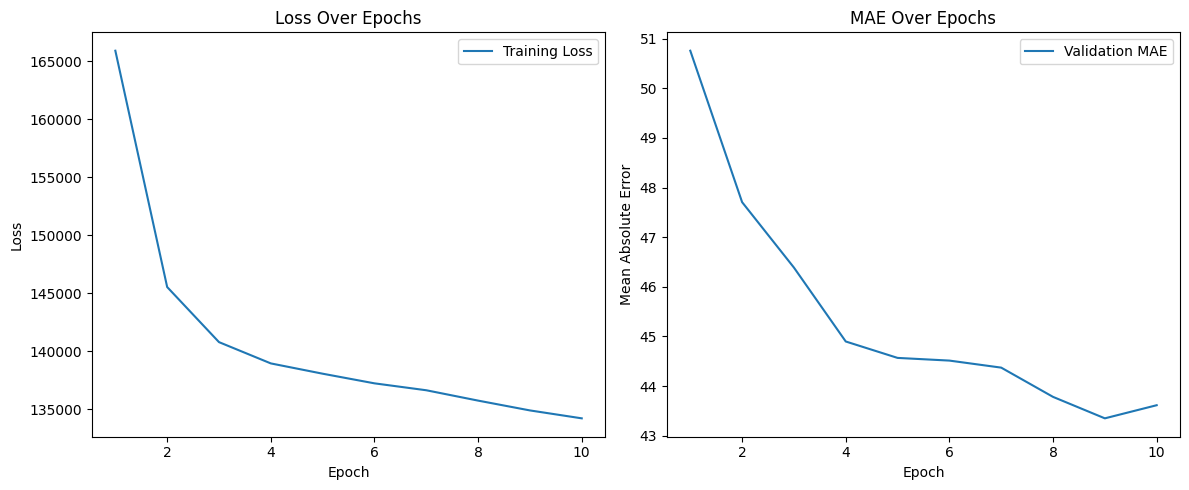


Lambda:
  MAE: 119.2124
  MSE: 916848.9674

Hinge B:
  MAE: 2.9432
  MSE: 12.6937

Hinge C:
  MAE: 6.0467
  MSE: 54.7705

Sample Predictions vs Actual Values:
Example 1:
  Actual: Lambda=1.6591, Hinge B=12.0000, Hinge C=26.0000
  Predicted: Lambda=-4.8576, Hinge B=15.9673, Hinge C=28.4694
Example 2:
  Actual: Lambda=78.9933, Hinge B=14.0000, Hinge C=27.0000
  Predicted: Lambda=27.8484, Hinge B=18.3468, Hinge C=31.4594
Example 3:
  Actual: Lambda=198.2658, Hinge B=22.0000, Hinge C=41.0000
  Predicted: Lambda=133.3954, Hinge B=26.3165, Hinge C=42.6192
Example 4:
  Actual: Lambda=155.7725, Hinge B=16.0000, Hinge C=21.0000
  Predicted: Lambda=203.6349, Hinge B=15.1729, Hinge C=27.4236
Example 5:
  Actual: Lambda=541.8596, Hinge B=5.0000, Hinge C=9.0000
  Predicted: Lambda=761.1308, Hinge B=2.6072, Hinge C=7.1629


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

df = pd.read_csv('arch_dataset_outputs.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nChecking for missing values:")
print(df.isnull().sum())

df = df.dropna()
print("\nShape after dropping NaN values:", df.shape)

features = ['Span', 'Thickness', 'Width', 'Blocks', 'Unit Weight', 'Load Position']
targets = ['Lambda', 'Hinge B', 'Hinge C']

X = df[features].values
y = df[targets].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2/0.7, random_state=42)

print(f"\nData split: Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nChecking for NaN values in training data:")
print("X_train_scaled NaN count:", np.isnan(X_train_scaled).sum())
print("y_train NaN count:", np.isnan(y_train).sum())

mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=8,
    learning_rate_init=0.001,
    max_iter=1,
    shuffle=True,
    random_state=42,
    warm_start=True
)

train_losses = []
val_maes = []
val_mses = []

print("\nTraining neural network:")
for epoch in range(10):
    mlp.fit(X_train_scaled, y_train)
    
    y_train_pred = mlp.predict(X_train_scaled)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_losses.append(mlp.loss_)
    
    y_val_pred = mlp.predict(X_val_scaled)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_maes.append(val_mae)
    val_mses.append(val_mse)
    
    print(f"Epoch {epoch+1}/10 - Loss: {mlp.loss_:.6f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}, Val MSE: {val_mse:.4f}")

y_test_pred = mlp.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("\nTest Results:")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), val_maes, label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

for i, target in enumerate(targets):
    target_mae = mean_absolute_error(y_test[:, i], y_test_pred[:, i])
    target_mse = mean_squared_error(y_test[:, i], y_test_pred[:, i])
    print(f"\n{target}:")
    print(f"  MAE: {target_mae:.4f}")
    print(f"  MSE: {target_mse:.4f}")

print("\nSample Predictions vs Actual Values:")
for i in range(min(5, len(X_test))):
    print(f"Example {i+1}:")
    print(f"  Actual: Lambda={y_test[i, 0]:.4f}, Hinge B={y_test[i, 1]:.4f}, Hinge C={y_test[i, 2]:.4f}")
    print(f"  Predicted: Lambda={y_test_pred[i, 0]:.4f}, Hinge B={y_test_pred[i, 1]:.4f}, Hinge C={y_test_pred[i, 2]:.4f}")

In [4]:
import numpy as np
import pandas as pd
from itertools import product
from tqdm import tqdm

# Configure tqdm to use percentage display
tqdm.pandas()

# Increased step sizes for faster computation
t_s_vals = np.round(np.arange(0.1, 1.51, 0.15), 2)  # Increased step from 0.1 to 0.2
span_vals = np.round(np.arange(0.5, 10.1, 1.0), 2)  # Increased step from 0.5 to 1.0
thickness_vals = []
for t_s in tqdm(t_s_vals, desc="Generating thickness values", bar_format='{desc}: {percentage:3.0f}%'):
    thickness_vals.extend([round(s * t_s, 3) for s in span_vals])
thickness_vals = list(set(thickness_vals))

width_vals = np.round(np.arange(3, 8.1, 0.5), 2)  # Increased step from 0.2 to 0.5
length_vals = [1]
wt_vals = np.arange(17, 23, 1)  # Increased step from 1 to 2
n_vals = np.arange(8, 32, 2)  # Increased step from 2 to 4

# Second progress bar
data = list(tqdm(product(t_s_vals, span_vals, thickness_vals, width_vals, length_vals, wt_vals, n_vals), 
                desc="Creating combinations", 
                bar_format='{desc}: {percentage:3.0f}%'))

df = pd.DataFrame(data, columns=['t_s', 'span', 'thickness', 'width', 'length', 'wt_kN_per_m3', 'n_blocks'])
df = df[df['thickness'] <= df['span']]
df = df[df['t_s'] == (df['thickness'] / df['span']).round(2)]
print("Total entries:", len(df))
df.to_csv("h_d.csv", index=False)

Generating thickness values: 100%
Creating combinations:   0%


Total entries: 68112


Dataset shape: (68112, 10)

First few rows:
   t_s  span  thickness  width  length  wt_kN_per_m3  n_blocks     alpha    b  \
0  0.1   0.5       0.05    3.0       1            17         8  0.435654  2.0   
1  0.1   0.5       0.05    3.0       1            17        10  0.422169  3.0   
2  0.1   0.5       0.05    3.0       1            17        12  0.413785  3.0   
3  0.1   0.5       0.05    3.0       1            17        14  0.400730  4.0   
4  0.1   0.5       0.05    3.0       1            17        16  0.397927  4.0   

      c  
0   7.0  
1   9.0  
2  10.0  
3  12.0  
4  13.0  

Checking for missing values:
t_s             0
span            0
thickness       0
width           0
length          0
wt_kN_per_m3    0
n_blocks        0
alpha           0
b               0
c               0
dtype: int64

Shape after dropping NaN values: (68112, 10)

Data split: Train: 34055, Validation: 13623, Test: 20434

Training neural network:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 10/100 - Loss: 0.065011, Train MAE: 0.2052, Val MAE: 0.2083, Val MSE: 0.1475, Val R²: 0.9579


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 20/100 - Loss: 0.051912, Train MAE: 0.1732, Val MAE: 0.1765, Val MSE: 0.1920, Val R²: 0.9636


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 30/100 - Loss: 0.043327, Train MAE: 0.1256, Val MAE: 0.1286, Val MSE: 0.0762, Val R²: 0.9721


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 40/100 - Loss: 0.033223, Train MAE: 0.1748, Val MAE: 0.1780, Val MSE: 0.2624, Val R²: 0.9531


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 50/100 - Loss: 0.034210, Train MAE: 0.1545, Val MAE: 0.1579, Val MSE: 0.2327, Val R²: 0.9550


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 60/100 - Loss: 0.030036, Train MAE: 0.2161, Val MAE: 0.2221, Val MSE: 0.3382, Val R²: 0.9171


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 70/100 - Loss: 0.025648, Train MAE: 0.1661, Val MAE: 0.1695, Val MSE: 0.2048, Val R²: 0.9411


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 80/100 - Loss: 0.025751, Train MAE: 0.1072, Val MAE: 0.1081, Val MSE: 0.0407, Val R²: 0.9752


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 90/100 - Loss: 0.024055, Train MAE: 0.1500, Val MAE: 0.1515, Val MSE: 0.0975, Val R²: 0.9567


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 100/100 - Loss: 0.022229, Train MAE: 0.1223, Val MAE: 0.1230, Val MSE: 0.0565, Val R²: 0.9705


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 110/100 - Loss: 0.020453, Train MAE: 0.0662, Val MAE: 0.0662, Val MSE: 0.0126, Val R²: 0.9914


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 120/100 - Loss: 0.020568, Train MAE: 0.1625, Val MAE: 0.1660, Val MSE: 0.2483, Val R²: 0.9570


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 130/100 - Loss: 0.020772, Train MAE: 0.2527, Val MAE: 0.2573, Val MSE: 0.4369, Val R²: 0.9420


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 140/100 - Loss: 0.018424, Train MAE: 0.0586, Val MAE: 0.0587, Val MSE: 0.0107, Val R²: 0.9936


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 150/100 - Loss: 0.020151, Train MAE: 0.0607, Val MAE: 0.0612, Val MSE: 0.0108, Val R²: 0.9937


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 160/100 - Loss: 0.018189, Train MAE: 0.0607, Val MAE: 0.0611, Val MSE: 0.0111, Val R²: 0.9946


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 170/100 - Loss: 0.017738, Train MAE: 0.0531, Val MAE: 0.0531, Val MSE: 0.0088, Val R²: 0.9946


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 180/100 - Loss: 0.014633, Train MAE: 0.0543, Val MAE: 0.0544, Val MSE: 0.0089, Val R²: 0.9947


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 190/100 - Loss: 0.014377, Train MAE: 0.0487, Val MAE: 0.0490, Val MSE: 0.0079, Val R²: 0.9945
Epoch 200/100 - Loss: 0.017659, Train MAE: 0.2401, Val MAE: 0.2446, Val MSE: 0.3630, Val R²: 0.9359
Epoch 210/100 - Loss: 0.015213, Train MAE: 0.0547, Val MAE: 0.0547, Val MSE: 0.0090, Val R²: 0.9951


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 220/100 - Loss: 0.014767, Train MAE: 0.0491, Val MAE: 0.0495, Val MSE: 0.0080, Val R²: 0.9947


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 230/100 - Loss: 0.015109, Train MAE: 0.0547, Val MAE: 0.0552, Val MSE: 0.0097, Val R²: 0.9945
Epoch 240/100 - Loss: 0.015845, Train MAE: 0.0527, Val MAE: 0.0527, Val MSE: 0.0084, Val R²: 0.9946


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 250/100 - Loss: 0.015140, Train MAE: 0.2123, Val MAE: 0.2142, Val MSE: 0.3847, Val R²: 0.9469


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 260/100 - Loss: 0.017104, Train MAE: 0.0453, Val MAE: 0.0454, Val MSE: 0.0068, Val R²: 0.9956
Epoch 270/100 - Loss: 0.011517, Train MAE: 0.0642, Val MAE: 0.0648, Val MSE: 0.0205, Val R²: 0.9912
Epoch 280/100 - Loss: 0.013244, Train MAE: 0.1343, Val MAE: 0.1375, Val MSE: 0.0950, Val R²: 0.9752
Epoch 290/100 - Loss: 0.011221, Train MAE: 0.0423, Val MAE: 0.0426, Val MSE: 0.0062, Val R²: 0.9957


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 300/100 - Loss: 0.011170, Train MAE: 0.0424, Val MAE: 0.0427, Val MSE: 0.0062, Val R²: 0.9956


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 310/100 - Loss: 0.011548, Train MAE: 0.1317, Val MAE: 0.1335, Val MSE: 0.2233, Val R²: 0.9636


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 320/100 - Loss: 0.009925, Train MAE: 0.0650, Val MAE: 0.0669, Val MSE: 0.0262, Val R²: 0.9884


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 330/100 - Loss: 0.012194, Train MAE: 0.0408, Val MAE: 0.0411, Val MSE: 0.0060, Val R²: 0.9938


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 340/100 - Loss: 0.012389, Train MAE: 0.0871, Val MAE: 0.0881, Val MSE: 0.0333, Val R²: 0.9905
Epoch 350/100 - Loss: 0.011094, Train MAE: 0.0750, Val MAE: 0.0766, Val MSE: 0.0264, Val R²: 0.9897


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 360/100 - Loss: 0.010698, Train MAE: 0.1424, Val MAE: 0.1472, Val MSE: 0.2396, Val R²: 0.9634


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 370/100 - Loss: 0.012748, Train MAE: 0.0950, Val MAE: 0.0971, Val MSE: 0.0504, Val R²: 0.9880
Epoch 380/100 - Loss: 0.011161, Train MAE: 0.0445, Val MAE: 0.0448, Val MSE: 0.0064, Val R²: 0.9955
Epoch 390/100 - Loss: 0.012022, Train MAE: 0.1205, Val MAE: 0.1220, Val MSE: 0.0747, Val R²: 0.9827
Epoch 400/100 - Loss: 0.010999, Train MAE: 0.0668, Val MAE: 0.0682, Val MSE: 0.0186, Val R²: 0.9878


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 410/100 - Loss: 0.011276, Train MAE: 0.0445, Val MAE: 0.0448, Val MSE: 0.0065, Val R²: 0.9948


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 420/100 - Loss: 0.010596, Train MAE: 0.0794, Val MAE: 0.0828, Val MSE: 0.0662, Val R²: 0.9837
Epoch 430/100 - Loss: 0.008513, Train MAE: 0.0474, Val MAE: 0.0480, Val MSE: 0.0070, Val R²: 0.9947
Epoch 440/100 - Loss: 0.008598, Train MAE: 0.0463, Val MAE: 0.0464, Val MSE: 0.0071, Val R²: 0.9947
Epoch 450/100 - Loss: 0.009332, Train MAE: 0.0439, Val MAE: 0.0440, Val MSE: 0.0064, Val R²: 0.9944
Epoch 460/100 - Loss: 0.009134, Train MAE: 0.0392, Val MAE: 0.0393, Val MSE: 0.0051, Val R²: 0.9955
Epoch 470/100 - Loss: 0.011364, Train MAE: 0.0402, Val MAE: 0.0405, Val MSE: 0.0054, Val R²: 0.9946
Epoch 480/100 - Loss: 0.013291, Train MAE: 0.1694, Val MAE: 0.1724, Val MSE: 0.1173, Val R²: 0.9794


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 490/100 - Loss: 0.008069, Train MAE: 0.0409, Val MAE: 0.0411, Val MSE: 0.0057, Val R²: 0.9951


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Epoch 500/100 - Loss: 0.009397, Train MAE: 0.0424, Val MAE: 0.0427, Val MSE: 0.0058, Val R²: 0.9954

Test Results:
Mean Absolute Error (MAE): 0.0427
Mean Squared Error (MSE): 0.0064
R² Score (Accuracy): 0.9954


ValueError: x and y must have same first dimension, but have shapes (100,) and (500,)

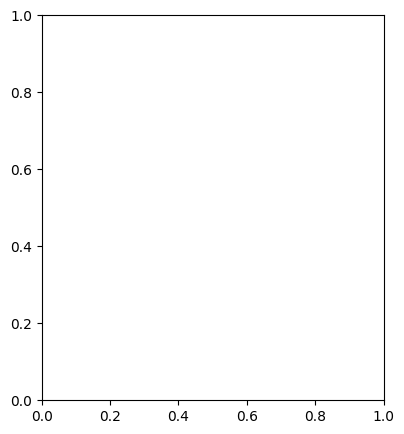

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

df = pd.read_csv('updated_hor_dtset.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nChecking for missing values:")
print(df.isnull().sum())

df = df.dropna()
print("\nShape after dropping NaN values:", df.shape)

features = ['span', 'thickness', 'width', 'wt_kN_per_m3', 'n_blocks']
targets = ['alpha', 'b', 'c']

X = df[features].values
y = df[targets].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2/0.7, random_state=42)

print(f"\nData split: Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=8,
    learning_rate_init=0.001,
    max_iter=1,
    shuffle=True,
    random_state=42,
    warm_start=True
)

train_losses = []
val_maes = []
val_mses = []
val_r2s = []

print("\nTraining neural network:")
for epoch in range(500):
    mlp.fit(X_train_scaled, y_train)
    
    y_train_pred = mlp.predict(X_train_scaled)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_losses.append(mlp.loss_)
    
    y_val_pred = mlp.predict(X_val_scaled)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    val_maes.append(val_mae)
    val_mses.append(val_mse)
    val_r2s.append(val_r2)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/100 - Loss: {mlp.loss_:.6f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}, Val MSE: {val_mse:.4f}, Val R²: {val_r2:.4f}")

y_test_pred = mlp.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nTest Results:")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"R² Score (Accuracy): {test_r2:.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 101), val_maes, label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, 101), val_r2s, label='Validation R²')
plt.title('R² Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

for i, target in enumerate(targets):
    target_mae = mean_absolute_error(y_test[:, i], y_test_pred[:, i])
    target_mse = mean_squared_error(y_test[:, i], y_test_pred[:, i])
    target_r2 = r2_score(y_test[:, i], y_test_pred[:, i])
    print(f"\n{target}:")
    print(f"  MAE: {target_mae:.4f}")
    print(f"  MSE: {target_mse:.4f}")
    print(f"  R² Score: {target_r2:.4f}")

print("\nSample Predictions vs Actual Values:")
for i in range(min(5, len(X_test))):
    print(f"Example {i+1}:")
    print(f"  Actual: alpha={y_test[i, 0]:.4f}, b={y_test[i, 1]:.4f}, c={y_test[i, 2]:.4f}")
    print(f"  Predicted: alpha={y_test_pred[i, 0]:.4f}, b={y_test_pred[i, 1]:.4f}, c={y_test_pred[i, 2]:.4f}")

plt.figure(figsize=(15, 5))
for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test[:, i], y_test_pred[:, i])
    plt.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r--')
    plt.title(f'Actual vs Predicted: {target}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
plt.tight_layout()
plt.savefig('prediction_scatter.png')
plt.show()